# Постановка задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# Анализ данных

## Подготовительные шаги

### Импортируем библиотеки

In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

### Определим константы

In [2]:
# random state

RS = 130223

# локальные пути к .csv файлам

PATH_1 = "data_arc.csv"
PATH_2 = "data_bulk.csv"
PATH_3 = "data_bulk_time.csv"
PATH_4 = "data_gas.csv"
PATH_5 = "data_temp.csv"
PATH_6 = "data_wire.csv"
PATH_7 = "data_wire_time.csv"


# пути к .csv файлам на сервере

PATH_1_ALT = "/datasets/data_arc.csv"
PATH_2_ALT = "/datasets/data_bulk.csv"
PATH_3_ALT = "/datasets/data_bulk_time.csv"
PATH_4_ALT = "/datasets/data_gas.csv"
PATH_5_ALT = "/datasets/data_temp.csv"
PATH_6_ALT = "/datasets/data_wire.csv"
PATH_7_ALT = "/datasets/data_wire_time.csv"

### Вспомогательные функции

#### Функция для открытия всех датафреймов

In [3]:
def paths_exist(paths: list) -> bool:
    """Получает на вход список путей к .csv файлам.
       Возвращает True, если все пути валидны, иначе False."""
    
    check = [os.path.exists(path) for path in paths]
    
    return all(check)

#### Функция для переименования

In [4]:
def proper_names(base_name: str, quantity: int) -> list:
    """Принимает смысловое название для коллекции имён
    и необходимое количество индексов. Возвращает список
    имён."""
    
    names = ['key']

    for index in range(1, quantity+1):
        names.append(
            f'{base_name}_{index}'
        )
        
    return names

#### Функция изменения формата времени и даты с object на DateTime

In [5]:
def time_format(column_names: list, data_frame: pd.DataFrame) -> None:
    """Принимает список имен столбцов с неверным типом времени
    и целевой датафрейм. Изменяет тип."""
    
    if 'key' in column_names:
        column_names.remove('key')
    
    for column_name in column_names:
        data_frame[column_name] = pd.to_datetime(
            data_frame[column_name],
            format='%Y-%m-%d %H:%M:%S'
        )

#### Функция расчета полной мощности

In [6]:
def full_power(data_frame: pd.DataFrame) -> pd.Series:
    """Расчет полной мощности, для использования
    в методе pd.DataFrame.apply."""
        
    full_power = math.sqrt(
        data_frame['power_active']**2
        + data_frame['power_reactive']**2
    )
    
    return full_power

#### Функция расчета времени нагрева

In [7]:
def heating_duration(data_frame: pd.DataFrame) -> pd.Series:
    """Расчет времени нагрева, для использования
    в методе pd.DataFrame.apply."""
        
    time_delta = (
        data_frame['arc_heating_finish']
        - data_frame['arc_heating_start']
    )
    
    return time_delta

#### Функция расчета совершённой работы

In [8]:
def work(data_frame: pd.DataFrame) -> pd.Series:
    """Расчет совершённой работы, для использования
    в методе pd.DataFrame.apply."""
        
    work_done = (
        data_frame['power_full']
        * data_frame['heating_duration']
    )
    
    return work_done

#### Функция слияния датасетов в итоговый

In [9]:
def merge_em_all(sets: list) -> pd.DataFrame:
    """Принимает на вход список датасетов, рекурсивно
    соединяет их по ключу, возвращает итоговый датасет.
    """
    
    if len(sets) == 1:
        return sets[0]
    
    elif len(sets) == 2:
        return sets[1].merge(
            sets[0],
            how='inner',
            on='key'
        )
    
    return merge_em_all(sets[:-1]).merge(
        sets[-1],
        how='inner',
        on='key'
    )

### Загрузим данные

In [10]:
local_paths = [
    PATH_1,
    PATH_2,
    PATH_3,
    PATH_4,
    PATH_5,
    PATH_6,
    PATH_7,
]

remote_paths = [
    PATH_1_ALT,
    PATH_2_ALT,
    PATH_3_ALT,
    PATH_4_ALT,
    PATH_5_ALT,
    PATH_6_ALT,
    PATH_7_ALT,
]

In [11]:
if paths_exist(local_paths):
    
    arc = pd.read_csv(PATH_1)
    bulk = pd.read_csv(PATH_2)
    bulk_time = pd.read_csv(PATH_3)
    gas = pd.read_csv(PATH_4)
    temp = pd.read_csv(PATH_5)
    wire = pd.read_csv(PATH_6)
    wire_time = pd.read_csv(PATH_7)
    
elif paths_exist(remote_paths):
    
    arc = pd.read_csv(PATH_1_ALT)
    bulk = pd.read_csv(PATH_2_ALT)
    bulk_time = pd.read_csv(PATH_3_ALT)
    gas = pd.read_csv(PATH_4_ALT)
    temp = pd.read_csv(PATH_5_ALT)
    wire = pd.read_csv(PATH_6_ALT)
    wire_time = pd.read_csv(PATH_7_ALT)
    
else:
    print('Расходимся! Циферок не подвезли...')

## Заглянем внутрь: предварительное знакомство

### Данные об электродах:

In [12]:
# посмотрим, что хранит первый набор данных

arc

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0         1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1         1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2         1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3         1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4         1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   
...     ...                  ...                  ...                ...   
14871  3241  2019-09-01 03:58:58  2019-09-01 04:01:35           0.533670   
14872  3241  2019-09-01 04:05:04  2019-09-01 04:08:04           0.676604   
14873  3241  2019-09-01 04:16:41  2019-09-01 04:19:45           0.733899   
14874  3241  2019-09-01 04:31:51  2019-09-01 04:32:48           0.220694   
14875  3241  2019-09-01 04:34:47  2019-09-01 04:36:08           0.306580   

       Реактивная мощность  
0                 0.687084  
1                 0.520285  
2                 0.498805  
3                 1.062669  
4                 0.414397  
...                    ...  
14871             0.354439  
14872             0.523631  
14873             0.475654  
14874             0.145768  
14875             0.196708  

[14876 rows x 5 columns]

Первое, что бросилось в глаза - это названия столбцов-признаков. Пока что не понятно нужны ли нам все представленные в датафрейме признаки, но фиксируем пункт **переименовать столбцы**.

In [13]:
# переименуем столбцы

arc.columns = [
    'key', 
    'arc_heating_start',
    'arc_heating_finish',
    'power_active', 
    'power_reactive'
]

In [14]:
# посмотрим на типы данных

arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 14876 non-null  int64  
 1   arc_heating_start   14876 non-null  object 
 2   arc_heating_finish  14876 non-null  object 
 3   power_active        14876 non-null  float64
 4   power_reactive      14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Тут стало ясно, что тип данных с датой и временем представлен не в том типе, нужно будет изменить тип данных фиксирующих время.

In [15]:
time_format(['arc_heating_start', 'arc_heating_finish'], arc)

In [16]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 14876 non-null  int64         
 1   arc_heating_start   14876 non-null  datetime64[ns]
 2   arc_heating_finish  14876 non-null  datetime64[ns]
 3   power_active        14876 non-null  float64       
 4   power_reactive      14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [17]:
arc.describe()

key  power_active  power_reactive
count  14876.000000  14876.000000    14876.000000
mean    1615.220422      0.670441        0.452592
std      934.571502      0.408159        5.878702
min        1.000000      0.030002     -715.504924
25%      806.000000      0.395297        0.290991
50%     1617.000000      0.555517        0.415962
75%     2429.000000      0.857034        0.637371
max     3241.000000      3.731596        2.676388

Заинтриговала отрицательная реактивная мощность. Не буду спешить с выводом, что это аномалия. Посмотрим на максимальные значения в power_reactive.

In [18]:
arc.sort_values(by=['power_reactive']).head()

key   arc_heating_start  arc_heating_finish  power_active  \
9780  2116 2019-07-24 00:44:48 2019-07-24 00:46:37      0.495782   
5596  1216 2019-06-16 08:22:19 2019-06-16 08:22:30      0.030188   
2419   521 2019-05-22 17:42:57 2019-05-22 17:43:11      0.030563   
4914  1060 2019-06-11 04:31:57 2019-06-11 04:32:08      0.031630   
4633  1000 2019-06-09 01:17:44 2019-06-09 01:17:57      0.038186   

      power_reactive  
9780     -715.504924  
5596        0.020806  
2419        0.021154  
4914        0.022485  
4633        0.022983

Вуаля! Все-таки power_reactive со значением -715 это аномальный выброс. Надо бы удалить.

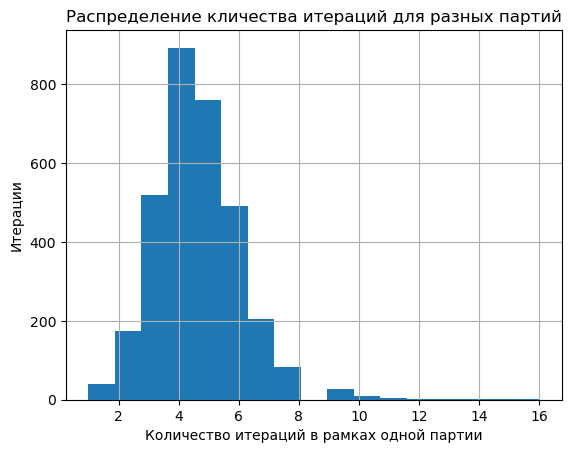

In [19]:
plt.figure()

iteration_distribution = arc.groupby('key')['power_reactive'].count().hist(bins=17)

iteration_distribution.set_title(
    'Распределение кличества итераций для разных партий'
)

iteration_distribution.set_xlabel(
    'Количество итераций в рамках одной партии'
)

iteration_distribution.set_ylabel('Итерации');

Судя по графику, обычно достаточно 4 или 5 итераций, чтобы получить сталь заданного качества

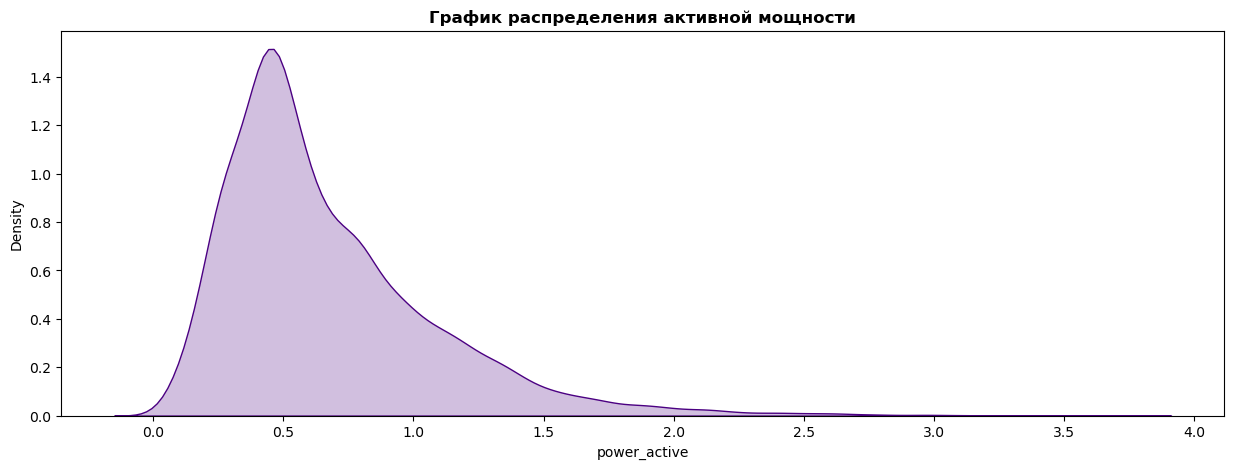

In [20]:
plt.figure(figsize=(15, 5))

fig = sns.kdeplot(
    arc['power_active'],
    color='indigo', 
    legend=True,
    fill=True
)

plt.title(
    'График распределения активной мощности',
    fontweight='bold'
)

plt.show();

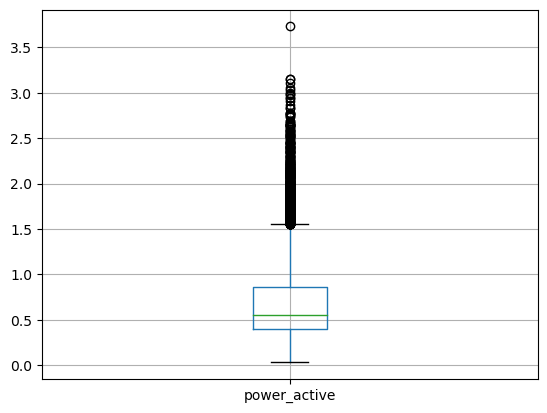

In [21]:
active_power_boxplot = arc.boxplot('power_active')

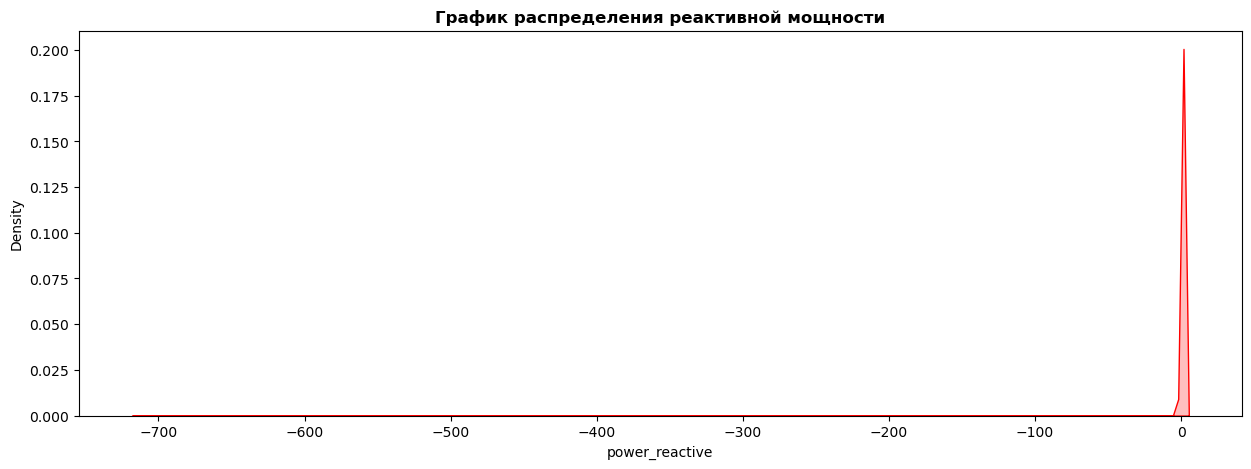

In [22]:
plt.figure(figsize=(15, 5))

fig = sns.kdeplot(
    arc['power_reactive'],
    color='r', 
    legend=True,
    fill=True
)

plt.title(
    'График распределения реактивной мощности', 
    fontweight='bold'
)

plt.show();

Значение -715 это явная аномалия перестроим график, исключив это значение по оси х

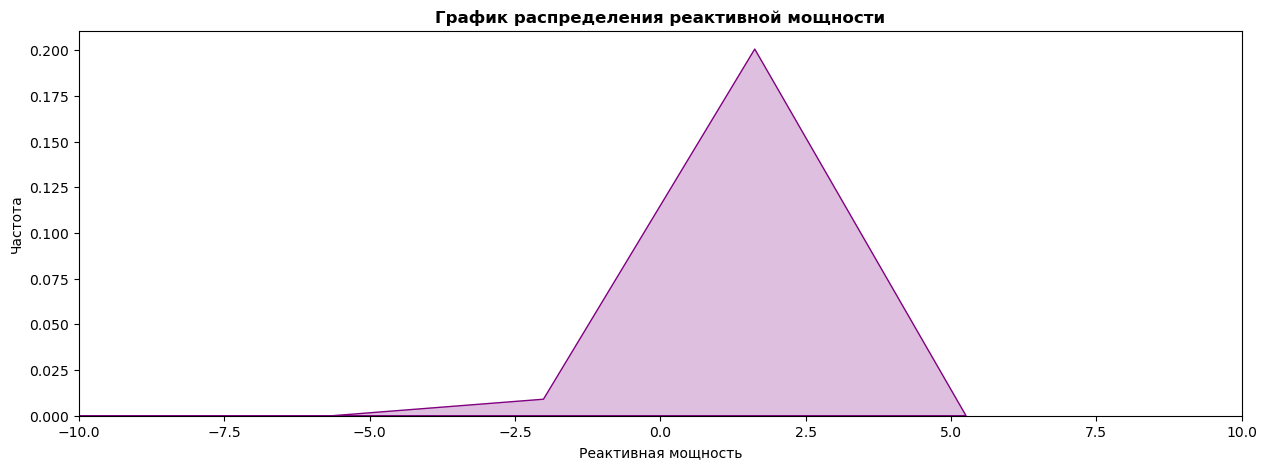

In [23]:
plt.figure(figsize=(15, 5))

fig = sns.kdeplot(
    arc['power_reactive'],
    color='purple', 
    legend=True,
    fill=True
)

plt.title(
    'График распределения реактивной мощности', 
    fontweight='bold'
)
plt.xlim(-10,10)
plt.xlabel('Реактивная мощность')
plt.ylabel('Частота')
plt.show();

ПОлученное распределение показывает, что реактивная мощность в основном находится на значении 2-2,2 (единицы измерения не известны)

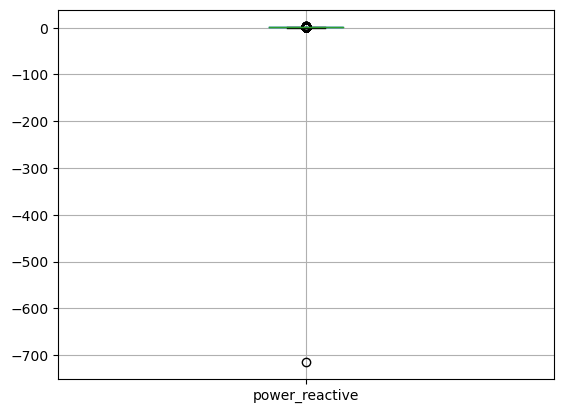

In [24]:
reactive_power_boxplot = arc.boxplot('power_reactive')

На графиках также виден выброс - отрицательная реактивная мощность

Не особо информативный график, я бы скорее его удалила, но просили показывать графически....как смогла....

**Итог:**

1) Были переименованы столбцы

2) Изменен тип данный фиксирующих нагрев и окончание нагрева.

3) Выявлена аномалия в параметре реактивного нагрева. Проблема осталось не решенной. (Я еще вспомнила, что все датафреймы мы сливаем по ключу и нельзя ничего удалять до общего объединения). Если не права- буду рада поправке.

4) Пропусков не обнаружено.

### Данные о подаче сыпучих материалов (объём и время):

In [25]:
bulk

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0        1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1        2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2        3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3        4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4        5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   
3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN     NaN   
3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0        NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1        NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2        NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3        NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4        NaN      NaN      NaN    203.0      NaN    151.0    152.0  
...      ...      ...      ...      ...      ...      ...      ...  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  
3127     NaN      NaN      NaN      NaN      NaN    192.0     54.0  
3128     NaN      NaN      NaN      NaN      NaN    180.0     52.0  

[3129 rows x 16 columns]

In [26]:
bulk_time

key Bulk 1 Bulk 2               Bulk 3               Bulk 4 Bulk 5  \
0        1    NaN    NaN                  NaN  2019-05-03 11:21:30    NaN   
1        2    NaN    NaN                  NaN  2019-05-03 11:46:38    NaN   
2        3    NaN    NaN                  NaN  2019-05-03 12:31:06    NaN   
3        4    NaN    NaN                  NaN  2019-05-03 12:48:43    NaN   
4        5    NaN    NaN                  NaN  2019-05-03 13:18:50    NaN   
...    ...    ...    ...                  ...                  ...    ...   
3124  3237    NaN    NaN  2019-08-31 22:51:28                  NaN    NaN   
3125  3238    NaN    NaN  2019-08-31 23:39:11                  NaN    NaN   
3126  3239    NaN    NaN                  NaN                  NaN    NaN   
3127  3240    NaN    NaN                  NaN                  NaN    NaN   
3128  3241    NaN    NaN                  NaN                  NaN    NaN   

                   Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
0                     NaN    NaN    NaN    NaN     NaN     NaN   
1                     NaN    NaN    NaN    NaN     NaN     NaN   
2                     NaN    NaN    NaN    NaN     NaN     NaN   
3                     NaN    NaN    NaN    NaN     NaN     NaN   
4                     NaN    NaN    NaN    NaN     NaN     NaN   
...                   ...    ...    ...    ...     ...     ...   
3124                  NaN    NaN    NaN    NaN     NaN     NaN   
3125                  NaN    NaN    NaN    NaN     NaN     NaN   
3126  2019-09-01 01:51:58    NaN    NaN    NaN     NaN     NaN   
3127  2019-09-01 03:12:40    NaN    NaN    NaN     NaN     NaN   
3128                  NaN    NaN    NaN    NaN     NaN     NaN   

                  Bulk 12 Bulk 13              Bulk 14              Bulk 15  
0     2019-05-03 11:03:52     NaN  2019-05-03 11:03:52  2019-05-03 11:03:52  
1     2019-05-03 11:40:20     NaN  2019-05-03 11:40:20  2019-05-03 11:40:20  
2     2019-05-03 12:09:40     NaN  2019-05-03 12:09:40  2019-05-03 12:09:40  
3     2019-05-03 12:41:24     NaN  2019-05-03 12:41:24  2019-05-03 12:41:24  
4     2019-05-03 13:12:56     NaN  2019-05-03 13:12:56  2019-05-03 13:12:56  
...                   ...     ...                  ...                  ...  
3124  2019-08-31 22:46:52     NaN  2019-08-31 22:46:52  2019-08-31 22:46:52  
3125  2019-08-31 23:33:09     NaN  2019-08-31 23:33:09  2019-08-31 23:33:09  
3126  2019-09-01 01:39:41     NaN  2019-09-01 01:33:25  2019-09-01 01:33:25  
3127                  NaN     NaN  2019-09-01 02:41:27  2019-09-01 02:41:27  
3128                  NaN     NaN  2019-09-01 04:05:34  2019-09-01 04:05:34  

[3129 rows x 16 columns]

Очень много пропусков. Как будто-то бы заполняли только часть.

Возможно для каждого типа стали нужен своя насыпная часть.

Например где-то нужен Ванадий, а где-то нет, следовательно, не для каждой партии будет насыпаться ванадий.

А вот какой-нибудь Хром (частая лигирующая добавка) будет почти каждый раз насыпаться.

После вебинара я поняла, что мои догадки были верны и смело заполню все пропуски нулями.

In [27]:
# подготовим подходящие имена...

proper_bulk_names = proper_names('bulk', 15)

In [28]:
# ...и переименуем столбцы

bulk.columns = proper_bulk_names
bulk_time.columns = proper_bulk_names

In [29]:
bulk.shape

(3129, 16)

In [30]:
bulk_time.shape

(3129, 16)

In [31]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [32]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Из 3129 записей у каждой секции только часть данных

In [33]:
time_format(proper_bulk_names, bulk_time)

In [34]:
# объем

bulk.describe()

key      bulk_1      bulk_2       bulk_3       bulk_4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           bulk_5      bulk_6      bulk_7  bulk_8      bulk_9     bulk_10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          bulk_11      bulk_12     bulk_13      bulk_14      bulk_15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Менее популярные сыпучие материалы я бы вообще удалила (номер 8 точно мутный какой-то)

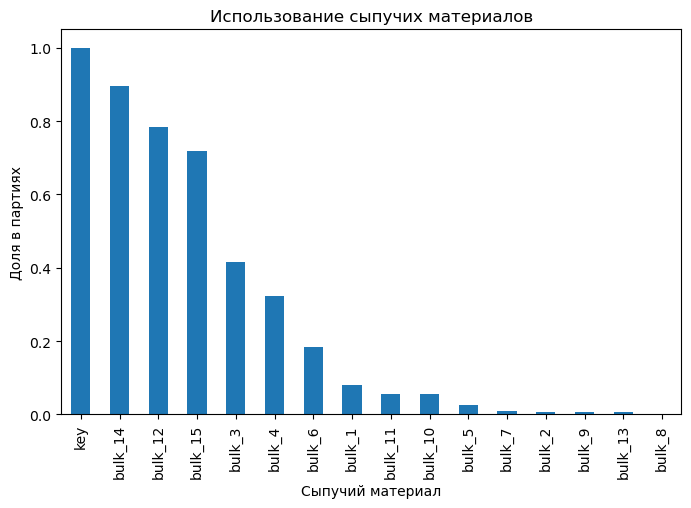

In [35]:
plt.figure(figsize=(8,5))

ax = (~bulk_time.isnull()).mean().sort_values(ascending=False).plot(kind='bar')

ax.set_title('Использование сыпучих материалов')
ax.set_ylabel('Доля в партиях')
ax.set_xlabel('Сыпучий материал');

**Итак,**

1) много пропусков. 

2) Если моё предположение верно, то избавиться от части менее популярных лигирующих сталь добавок. От номера 8 точно избавлюсь, если при слиянии всех датафреймов "ключ" с добавкой 8 останется.

3) Пропуски я бы нулём заполнила. Хотя для некоторых моделей (насколько я помню) можно и наны оставить (кэтбуст вроде бы всеядный)

4) Параметр времени привела к дейттайму

### Данные о продувке сплава газом:

In [36]:
gas

key      Газ 1
0        1  29.749986
1        2  12.555561
2        3  28.554793
3        4  18.841219
4        5   5.413692
...    ...        ...
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

[3239 rows x 2 columns]

Сразу вижу параметр на русском. Диагноз - переименовать!

Я капризная и для более глубогого понимания мне по-прежнему не хватает единиц измерения. Тут, надеюсь, объем в м3.

Где-то много, где-то не очень....смотрим дальше

In [37]:
gas.columns = proper_names('gas', 1)

In [38]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [39]:
gas.describe()

key        gas_1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

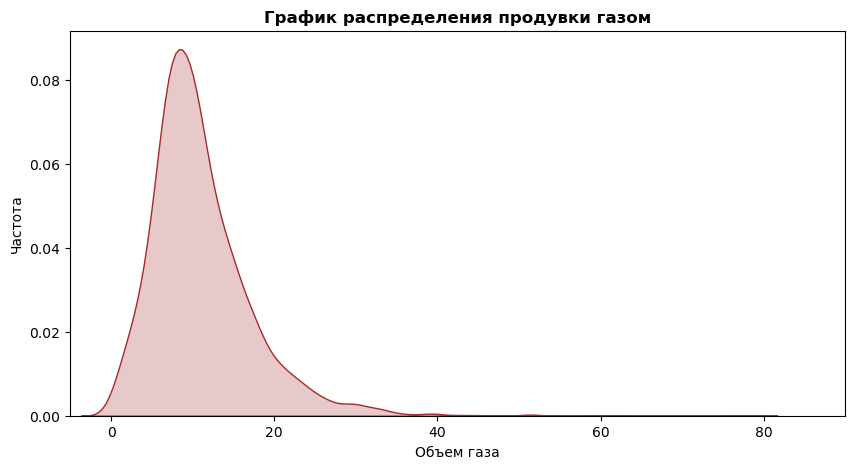

In [40]:
plt.figure(figsize=(10, 5))

fig = sns.kdeplot(
    gas['gas_1'],
    color='brown', 
    legend=True,
    fill=True
)

plt.title(
    'График распределения продувки газом',
    fontweight='bold'
)
plt.xlim(-5,90)
plt.xlabel('Объем газа')
plt.ylabel('Частота')
plt.show();

По графику  видно, что чаще всего хватает 10 объемов газа. 

Отрицательное значение газа интригует, что там за вакуум пытались воссоздать, котого нет в описании (тут я имею ввиду дискрайб)

В основном на процесс используется до 20 объемов газа

но есть и высокое количество значений объемов: от 40 до 80.

Если бы знать более глубоко процесс, стоймость газа, то можно капнуть глуже и попробовать разобраться почему довольно широкий диапазон, но тут задача в ином, поэтому не буду заострять на этом внимание.

**В итоге**

1) похоже, аномалий нет 

2) переименовала столбец

###  Данные о проволочных материалах (объём и время):

In [41]:
wire

key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998      NaN     NaN     NaN     NaN     NaN     NaN   
1        2   96.052315      NaN     NaN     NaN     NaN     NaN     NaN   
2        3   91.160157      NaN     NaN     NaN     NaN     NaN     NaN   
3        4   89.063515      NaN     NaN     NaN     NaN     NaN     NaN   
4        5   89.238236  9.11456     NaN     NaN     NaN     NaN     NaN   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959      NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799      NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761      NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400      NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595      NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
0        NaN     NaN  
1        NaN     NaN  
2        NaN     NaN  
3        NaN     NaN  
4        NaN     NaN  
...      ...     ...  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN  

[3081 rows x 10 columns]

In [42]:
wire_time

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5  \
0        1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN   
1        2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN   
2        3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN   
3        4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN   
4        5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN   
...    ...                  ...                  ...    ...    ...    ...   
3076  3237  2019-08-31 22:50:20                  NaN    NaN    NaN    NaN   
3077  3238  2019-08-31 23:38:24                  NaN    NaN    NaN    NaN   
3078  3239  2019-09-01 01:50:43                  NaN    NaN    NaN    NaN   
3079  3240  2019-09-01 03:12:02                  NaN    NaN    NaN    NaN   
3080  3241  2019-09-01 04:16:01                  NaN    NaN    NaN    NaN   

     Wire 6 Wire 7 Wire 8 Wire 9  
0       NaN    NaN    NaN    NaN  
1       NaN    NaN    NaN    NaN  
2       NaN    NaN    NaN    NaN  
3       NaN    NaN    NaN    NaN  
4       NaN    NaN    NaN    NaN  
...     ...    ...    ...    ...  
3076    NaN    NaN    NaN    NaN  
3077    NaN    NaN    NaN    NaN  
3078    NaN    NaN    NaN    NaN  
3079    NaN    NaN    NaN    NaN  
3080    NaN    NaN    NaN    NaN  

[3081 rows x 10 columns]

Схожая с балками проблема - много пропусков в параметрах.

In [43]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [44]:
proper_wire_names = proper_names('wire', 9)

In [45]:
# переименуем столбцы:

wire.columns = proper_wire_names
wire_time.columns = proper_wire_names

In [46]:
# приведем время к нужному типу:

time_format(proper_wire_names, wire_time)

In [47]:
# объем

wire.describe()

key       wire_1       wire_2      wire_3      wire_4  wire_5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           wire_6     wire_7      wire_8     wire_9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

In [48]:
# время

wire_time.describe()

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

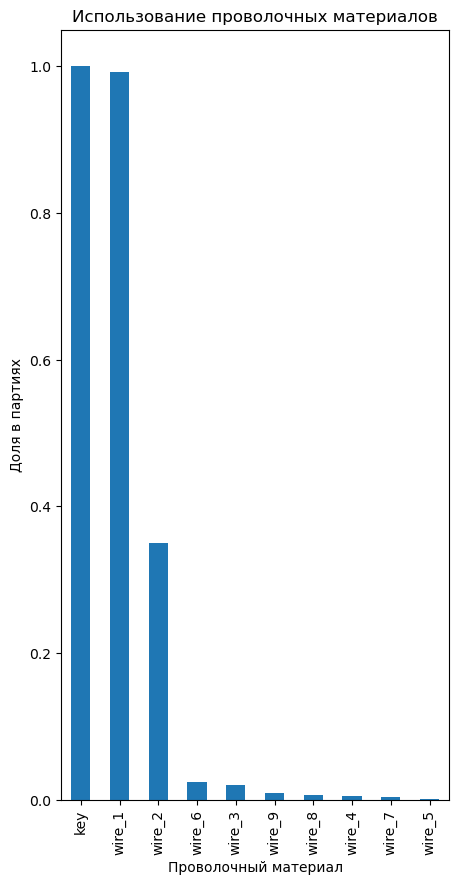

In [49]:
plt.figure(figsize = (5,10))
ax = (~wire_time.isnull()).mean().sort_values(ascending=False).plot(kind='bar')

ax.set_title('Использование проволочных материалов')
ax.set_ylabel('Доля в партиях')
ax.set_xlabel('Проволочный материал');

Чаще всего используется проволочный материал под номером 1. 

Потом по популярности номер 2. 

Номер 5 самый менее востребованный.

Номера 6 и 3 используются редко, но чаще чем другие. 

### Результаты измерения температуры:

In [50]:
temp

key         Время замера  Температура
0         1  2019-05-03 11:16:18       1571.0
1         1  2019-05-03 11:25:53       1604.0
2         1  2019-05-03 11:29:11       1618.0
3         1  2019-05-03 11:30:01       1601.0
4         1  2019-05-03 11:30:39       1613.0
...     ...                  ...          ...
15902  3241  2019-09-01 04:03:30       1586.0
15903  3241  2019-09-01 04:16:12          NaN
15904  3241  2019-09-01 04:22:39          NaN
15905  3241  2019-09-01 04:33:42          NaN
15906  3241  2019-09-01 04:38:08          NaN

[15907 rows x 3 columns]

In [51]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [52]:
temp.describe()

key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

In [53]:
# переименуем столбцы:

temp.columns = [
    'key',
    'probe_time',
    'temperature'
]

In [54]:
# приведем время к нужному типу:

time_format(['probe_time'], temp)

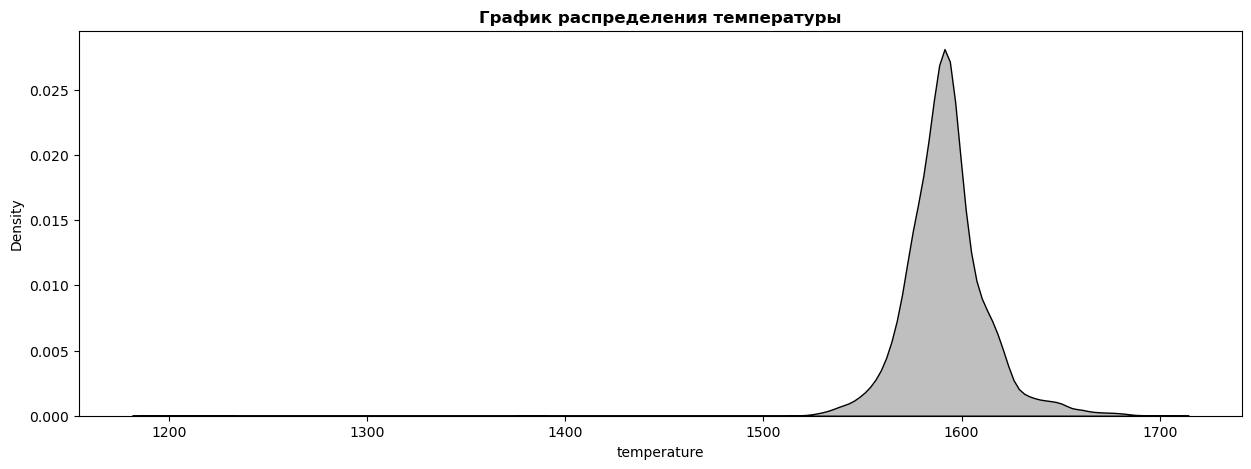

In [55]:
plt.figure(figsize=(15, 5))

fig = sns.kdeplot(
    temp['temperature'],
    color='black', 
    legend=True,
    fill=True
)

plt.title(
    'График распределения температуры',
    fontweight='bold'
)

plt.show();

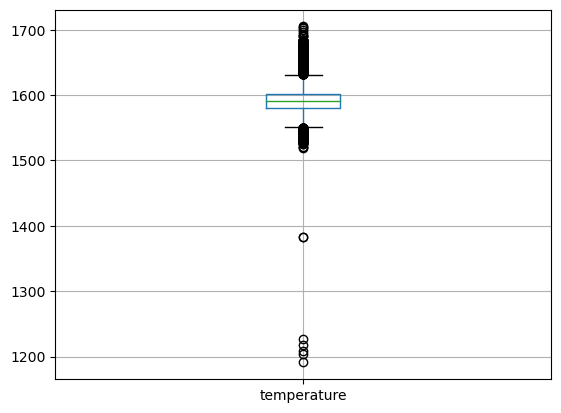

In [56]:
temperature_boxplot = temp.boxplot('temperature')

Похоже, ещё одна аномалия: температура целевой марки стали не может быть ниже 1500 градусов.

### Результаты проведенного первичного осмотра данных.

1]. Все 7 датасетов имеют общий параметр key (по которому скорее всего будем объединять данные);

2]. В некоторых датафреймах (с параметрами времени снятия данных) были изменены типы данных с object на DateTime.

3]. Обнаружена аномалия в датафрейме arc параметр power_reactive, решение которой пока что не найдено и из вебинара мне понятнее не стало.

4]. Также есть аномалия в температуре.

5]. Аномалии планирую удалить вместе с ключами, если после слияния они остануться, если не буду попадать в метрику, то попробую их вернуть, но под корректировать. Верну с целью увеличения набора данных - иногда помогало мне.

6]. Пропуски в данных заменю нулями. (филлна мне в помощь)

7]. После анализа вопросов стало больше, поэтому они обязатльно будут в конце.

# Обработка данных

## Обработка выбросов

### Аномальная реактивная мощность

Уточним, под каким ключом прячется отрицательная реактивная мощность:

In [57]:
arc.loc[arc['power_reactive'] < 0]

key   arc_heating_start  arc_heating_finish  power_active  \
9780  2116 2019-07-24 00:44:48 2019-07-24 00:46:37      0.495782   

      power_reactive  
9780     -715.504924

Удалим все записи из датасета arc под ключом 2116:

In [58]:
# вспомним размерность arc:

arc.shape

(14876, 5)

In [59]:
# уточним, сколько записей в arc под ключом 2116:

len(arc.loc[arc['key'] == 2116])

4

In [60]:
# удалим записи по ключу:

arc = arc.drop(np.where(arc['key'] == 2116)[0])                  

In [61]:
# проверим, что ключа больше нет:

arc.loc[arc['key'] == 2116]

Empty DataFrame
Columns: [key, arc_heating_start, arc_heating_finish, power_active, power_reactive]
Index: []

In [62]:
# проконтролируем размерность:

arc.shape

(14872, 5)

### Аномальная температура

In [63]:
# посмотрим на ключи, по которым скрывается аномальная температура:

keys_to_drop = temp.loc[temp['temperature'] < 1500, 'key'].to_list()

keys_to_drop

[867, 1214, 1619, 1818, 1818, 2052, 2561]

In [64]:
# количество записей на удаление:

len(temp.loc[temp['key'].isin(keys_to_drop)])

50

In [65]:
# размерность до...

temp.shape

(15907, 3)

In [66]:
# ...удаления...

temp = temp.loc[~temp['key'].isin(keys_to_drop)]

In [67]:
# ...и после

temp.shape

(15857, 3)

## Обработка пропусков

In [68]:
# заменим пропуски на нули:

bulk = bulk.fillna(0)

In [69]:
bulk

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0        1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1        2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2        3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3        4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4        5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3124  3237     0.0     0.0   170.0     0.0     0.0     0.0     0.0     0.0   
3125  3238     0.0     0.0   126.0     0.0     0.0     0.0     0.0     0.0   
3126  3239     0.0     0.0     0.0     0.0     0.0   114.0     0.0     0.0   
3127  3240     0.0     0.0     0.0     0.0     0.0    26.0     0.0     0.0   
3128  3241     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0        0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1        0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2        0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3        0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4        0.0      0.0      0.0    203.0      0.0    151.0    152.0  
...      ...      ...      ...      ...      ...      ...      ...  
3124     0.0      0.0      0.0    252.0      0.0    130.0    206.0  
3125     0.0      0.0      0.0    254.0      0.0    108.0    106.0  
3126     0.0      0.0      0.0    158.0      0.0    270.0     88.0  
3127     0.0      0.0      0.0      0.0      0.0    192.0     54.0  
3128     0.0      0.0      0.0      0.0      0.0    180.0     52.0  

[3129 rows x 16 columns]

In [70]:
# аналогично:

wire = wire.fillna(0)

In [71]:
wire

key      wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  \
0        1   60.059998  0.00000     0.0     0.0     0.0     0.0     0.0   
1        2   96.052315  0.00000     0.0     0.0     0.0     0.0     0.0   
2        3   91.160157  0.00000     0.0     0.0     0.0     0.0     0.0   
3        4   89.063515  0.00000     0.0     0.0     0.0     0.0     0.0   
4        5   89.238236  9.11456     0.0     0.0     0.0     0.0     0.0   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959  0.00000     0.0     0.0     0.0     0.0     0.0   
3077  3238   56.128799  0.00000     0.0     0.0     0.0     0.0     0.0   
3078  3239  143.357761  0.00000     0.0     0.0     0.0     0.0     0.0   
3079  3240   34.070400  0.00000     0.0     0.0     0.0     0.0     0.0   
3080  3241   63.117595  0.00000     0.0     0.0     0.0     0.0     0.0   

      wire_8  wire_9  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  
...      ...     ...  
3076     0.0     0.0  
3077     0.0     0.0  
3078     0.0     0.0  
3079     0.0     0.0  
3080     0.0     0.0  

[3081 rows x 10 columns]

In [72]:
#Удалим пропущенные значения

temp.dropna().reset_index(drop = True)


key          probe_time  temperature
0         1 2019-05-03 11:16:18       1571.0
1         1 2019-05-03 11:25:53       1604.0
2         1 2019-05-03 11:29:11       1618.0
3         1 2019-05-03 11:30:01       1601.0
4         1 2019-05-03 11:30:39       1613.0
...     ...                 ...          ...
12956  3237 2019-08-31 22:44:04       1569.0
12957  3238 2019-08-31 23:30:31       1584.0
12958  3239 2019-09-01 01:31:47       1598.0
12959  3240 2019-09-01 02:39:01       1617.0
12960  3241 2019-09-01 04:03:30       1586.0

[12961 rows x 3 columns]

In [73]:
temp

key          probe_time  temperature
0         1 2019-05-03 11:16:18       1571.0
1         1 2019-05-03 11:25:53       1604.0
2         1 2019-05-03 11:29:11       1618.0
3         1 2019-05-03 11:30:01       1601.0
4         1 2019-05-03 11:30:39       1613.0
...     ...                 ...          ...
15902  3241 2019-09-01 04:03:30       1586.0
15903  3241 2019-09-01 04:16:12          NaN
15904  3241 2019-09-01 04:22:39          NaN
15905  3241 2019-09-01 04:33:42          NaN
15906  3241 2019-09-01 04:38:08          NaN

[15857 rows x 3 columns]

# Подготовка данных перед обучением моделей

## Дополнительные признаки

### Полная мощность

Формула полной мощности имеет вид:

$$
S = \sqrt{P^2 \cdot Q^2}
$$

Где:

$P$ - активная мощность

$Q$ - реактивная мощность

$S$ - полная мощность

In [74]:
# добавим дополнительный признак, полную мощность:

arc['power_full'] = arc.apply(full_power, axis=1)

### Продолжительность нагрева

Представим его, как разность времени конца и времени начала нагрева:

$$
\Delta t = t_{конца} - t_{начала}
$$

In [75]:
# сформируем дополнительный признак:

duration = arc.apply(heating_duration, axis=1)

In [76]:
# поменяем тип данных признака для последующей группировки:

duration = duration/ np.timedelta64(1, 's')

In [77]:
# добавим признак в датасет:

arc['heating_duration'] = duration

### Совершённая работа

Определяется по формуле:

$$
A = S \cdot t
$$

Где:

$A$ - работа

$S$ - полная мощность

$t$ - время

In [78]:
# добавим новый признак:

arc['work'] = arc.apply(work, axis=1)

### Целевой признак: конечная температура

In [79]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15857 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          15857 non-null  int64         
 1   probe_time   15857 non-null  datetime64[ns]
 2   temperature  12961 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 495.5 KB


In [80]:
# посмотрим, сколько ключей с единичным замером температуры

single_measure = temp.groupby(by='key')['temperature'].count()

In [81]:
single_measure_keys = single_measure.loc[single_measure==1]

In [82]:
single_measure_keys

key
195     1
279     1
2500    1
2501    1
2502    1
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: temperature, Length: 740, dtype: int64

In [83]:
# составим список ключей для дропа

more_keys_to_drop = single_measure_keys.index.tolist()

In [84]:
temp.shape

(15857, 3)

In [85]:
# ...дропнем их

temp = temp.loc[~temp['key'].isin(more_keys_to_drop)]

In [86]:
temp.shape

(12221, 3)

In [87]:
# сгруппируем датасет с температурой по ключу, 
# оставим первое и последнее значения температуры:

temp = temp.groupby(by ='key').agg(['first', 'last']).reset_index()

In [88]:
temp.columns = temp.columns.droplevel()

In [89]:
temp

first                last   first    last
0        1 2019-05-03 11:16:18 2019-05-03 11:30:39  1571.0  1613.0
1        2 2019-05-03 11:37:27 2019-05-03 11:59:12  1581.0  1602.0
2        3 2019-05-03 12:13:17 2019-05-03 12:34:57  1596.0  1599.0
3        4 2019-05-03 12:52:57 2019-05-03 12:59:25  1601.0  1625.0
4        5 2019-05-03 13:23:19 2019-05-03 13:36:01  1576.0  1602.0
...    ...                 ...                 ...     ...     ...
2465  2495 2019-08-06 00:35:45 2019-08-06 00:54:42  1570.0  1591.0
2466  2496 2019-08-06 01:02:54 2019-08-06 01:29:52  1554.0  1591.0
2467  2497 2019-08-06 01:41:53 2019-08-06 01:53:50  1571.0  1589.0
2468  2498 2019-08-06 02:03:49 2019-08-06 02:25:31  1591.0  1594.0
2469  2499 2019-08-06 02:40:25 2019-08-06 03:00:28  1569.0  1603.0

[2470 rows x 5 columns]

In [90]:
# переименуем столбцы, ограничим новый датасет температуры:

temp.columns = ['key', 'time_1', 'time_2','temp_first','temp_final']

In [91]:
temp

key              time_1              time_2  temp_first  temp_final
0        1 2019-05-03 11:16:18 2019-05-03 11:30:39      1571.0      1613.0
1        2 2019-05-03 11:37:27 2019-05-03 11:59:12      1581.0      1602.0
2        3 2019-05-03 12:13:17 2019-05-03 12:34:57      1596.0      1599.0
3        4 2019-05-03 12:52:57 2019-05-03 12:59:25      1601.0      1625.0
4        5 2019-05-03 13:23:19 2019-05-03 13:36:01      1576.0      1602.0
...    ...                 ...                 ...         ...         ...
2465  2495 2019-08-06 00:35:45 2019-08-06 00:54:42      1570.0      1591.0
2466  2496 2019-08-06 01:02:54 2019-08-06 01:29:52      1554.0      1591.0
2467  2497 2019-08-06 01:41:53 2019-08-06 01:53:50      1571.0      1589.0
2468  2498 2019-08-06 02:03:49 2019-08-06 02:25:31      1591.0      1594.0
2469  2499 2019-08-06 02:40:25 2019-08-06 03:00:28      1569.0      1603.0

[2470 rows x 5 columns]

In [92]:
# перепроверим, остались ли у нас наблюдения, где
# проводился единственный замер температуры:

temp.loc[temp['time_1'] == temp['time_2']]

Empty DataFrame
Columns: [key, time_1, time_2, temp_first, temp_final]
Index: []

In [93]:
# ...и сколько мы имеем совпадений в первом и последнем замере:

len(temp.loc[temp['temp_first'] == temp['temp_final']])

42

Ну вот, не так много, но можем и оставить их

<AxesSubplot:>

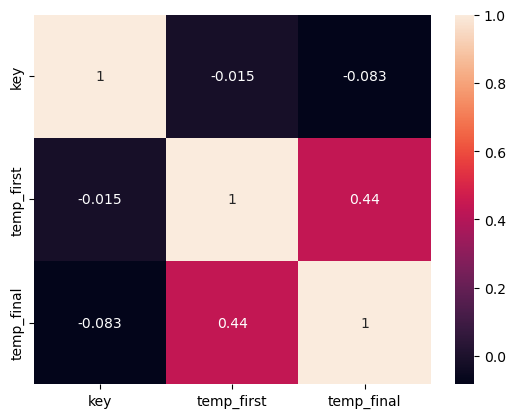

In [94]:
# посмотрим корреляцию на датасете

sns.heatmap(temp.corr(), annot=True)

In [95]:
temp = temp[['key','temp_first','temp_final']]

In [96]:
# в итоге было принято решение оставить дроп всех совпадений:

temp = temp.drop(np.where(temp['temp_first'] == temp['temp_final'])[0])   

In [97]:
temp

key  temp_first  temp_final
0        1      1571.0      1613.0
1        2      1581.0      1602.0
2        3      1596.0      1599.0
3        4      1601.0      1625.0
4        5      1576.0      1602.0
...    ...         ...         ...
2465  2495      1570.0      1591.0
2466  2496      1554.0      1591.0
2467  2497      1571.0      1589.0
2468  2498      1591.0      1594.0
2469  2499      1569.0      1603.0

[2428 rows x 3 columns]

<AxesSubplot:>

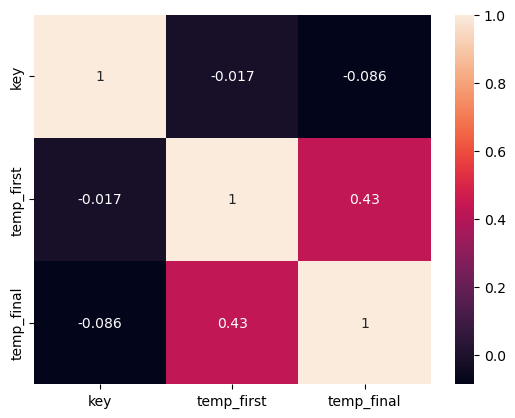

In [98]:
# корреляция после дропа всех совпадений

sns.heatmap(temp.corr(), annot=True)

## Подготовка данных к объединению

In [99]:
temp

key  temp_first  temp_final
0        1      1571.0      1613.0
1        2      1581.0      1602.0
2        3      1596.0      1599.0
3        4      1601.0      1625.0
4        5      1576.0      1602.0
...    ...         ...         ...
2465  2495      1570.0      1591.0
2466  2496      1554.0      1591.0
2467  2497      1571.0      1589.0
2468  2498      1591.0      1594.0
2469  2499      1569.0      1603.0

[2428 rows x 3 columns]

### Сравним размерности

In [100]:
arc.shape

(14872, 8)

In [101]:
gas.shape

(3239, 2)

In [102]:
bulk.shape

(3129, 16)

In [103]:
wire.shape

(3081, 10)

In [104]:
temp.shape

(2428, 3)

Итак, видно, что в arc у нас по-прежнему значительно больше записей, чем в других датасетах, так как он пока не сгруппирован. Исправим это

###  Сгруппируем датасет нагрева дугой по ключу

In [105]:
arc = arc.groupby(by ='key').mean(['power_full']).reset_index()

## Объединение данных в итоговый датасет

### Объединим датасеты

In [106]:
# дальше поедут только те данные, которые не содержат в названии "_time":

sets = [arc, bulk, wire, gas, temp]

In [107]:
# сольем все датасеты вместе по столбцу 'key',
# возьмем только те записи, ключи которых присутствуют во всех датасетах

full_set = merge_em_all(sets)

In [108]:
# избавимся от излишеств:

columns_to_drop = ['key', 'power_active', 'power_reactive', 'bulk_8', 'wire_5']

full_set = full_set.drop(columns_to_drop, axis=1)

In [109]:
full_set

bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_9  bulk_10  \
0        0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0      0.0   
1        0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0      0.0   
2        0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0      0.0   
3        0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0      0.0   
4        0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0      0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...      ...   
2283     0.0     0.0    21.0     0.0     0.0     0.0     0.0     0.0     90.0   
2284     0.0     0.0     0.0    63.0     0.0     0.0     0.0     0.0    122.0   
2285     0.0     0.0     0.0    85.0     0.0     0.0     0.0     0.0      0.0   
2286     0.0     0.0    90.0     0.0     0.0     0.0     0.0     0.0    101.0   
2287     0.0     0.0    47.0     0.0     0.0     0.0     0.0     0.0      0.0   

      bulk_11  ...    wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  wire_9  \
0         0.0  ...   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0  ...   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0  ...   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0  ...   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0  ...   9.11456     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...  ...       ...     ...     ...     ...     ...     ...     ...   
2283      0.0  ...   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2284      0.0  ...   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2285      0.0  ...   9.04800     0.0     0.0     0.0     0.0     0.0     0.0   
2286      0.0  ...   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2287      0.0  ...  50.00528     0.0     0.0     0.0     0.0     0.0     0.0   

          gas_1  temp_first  temp_final  
0     29.749986      1571.0      1613.0  
1     12.555561      1581.0      1602.0  
2     28.554793      1596.0      1599.0  
3     18.841219      1601.0      1625.0  
4      5.413692      1576.0      1602.0  
...         ...         ...         ...  
2283   7.125735      1570.0      1591.0  
2284   9.412616      1554.0      1591.0  
2285   6.271699      1571.0      1589.0  
2286  14.953657      1591.0      1594.0  
2287  11.336151      1569.0      1603.0  

[2288 rows x 28 columns]

1) Сразу бросается в галаза высокая зависимость wire_8 и bulk_9 равная 0.974966. Возможно лигирующая добавка под номером 9 обязательно идет вместе с проволкой под номером 8.

2) Из этой же части зависимостей видно, что часто используется комбинация двух добавок 2 и 7 (bulk_7 и bulk_2)

3) Добавка 7 имеет высокое знаение с проволкой 4 (bulk_7 и wire_4 корреляция составляет 0.740552).

4) Чуть меньше зависимость у добавки номер 2 и проволочной добавки номер 4. Видимо на производстве часто используется именно такие комбинации материалов при производстве стали.

5) Также высокая взаимосвязь мощности, нагрева и полезной работы (вполне логично).





## Подготовка выборок для обучения моделей

### Выделим features и target

In [111]:
target = full_set['temp_final']

In [112]:
features = full_set.drop('temp_final', axis=1)

### Разделим данные на тренировочную и тестовую выборки

In [113]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=RS,
)

### Проведем масштабирование

In [114]:
scaler = StandardScaler()
scaler.fit(features_train);

In [115]:
scaled_features_train = scaler.transform(features_train)
scaled_features_test = scaler.transform(features_test)

# Выбор и обучение моделей

## Linear Regression

In [116]:
%%time

# кросс-валидация для модели линейной регрессии

model_linear = LinearRegression()

mae_linear_cv = (
    cross_val_score(
        model_linear, 
        scaled_features_train, 
        target_train, 
        cv=7, 
        scoring='neg_mean_absolute_error'
    ).mean() * -1
)

CPU times: total: 93.8 ms
Wall time: 61 ms


In [117]:
# выведем MAE:

print(
    'Значение метрики MAE на обучающей выборке у модели линейной регрессии составляет :',
    mae_linear_cv
)

Значение метрики MAE на обучающей выборке у модели линейной регрессии составляет : 6.914284353848109


~вкусновато, но маловато~

Великовато, если на тренировойной она дает результат выше порогового, то на тестовой будет провал. Думаю, что в очередной раз Линейная регрессия в пройгрыше.

## Random Forest Regressor

Подберем гиперпараметры для леса:

In [118]:
forest_for_grid_search = RandomForestRegressor()

In [119]:
%%time

grid = {
    'criterion': ['absolute_error'],
    'n_estimators': [180, 200, 10],
    'max_depth': [8, 10, 2],
    'random_state': [RS],
    'min_samples_leaf': [4, 5, 1]
}

grid_forest = GridSearchCV(
    forest_for_grid_search,
    param_grid = grid,
    scoring='neg_mean_absolute_error',
    cv=7
)

grid_forest.fit(scaled_features_train, target_train)

print(grid_forest.best_params_)

{'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 180, 'random_state': 130223}
CPU times: total: 30min 33s
Wall time: 30min 56s


In [120]:
mae_forest_cv = grid_forest.best_score_ * -1

mae_forest_cv

6.817356742542161

{'criterion': 'mae', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200, 'random_state': 130223}
CPU times: user 31min 39s, sys: 5.6 s, total: 31min 45s
Wall time: 33min 43s

Случайный лес показвает результат немного лучше линейной регрессии при кросс-валидации

## CatBoost Regressor

Подберем гиперпараметры для CatBoost:

In [121]:
model_cat_for_grid = CatBoostRegressor(
    random_state=RS,
    loss_function='MAE',
    eval_metric='MAE'
)

In [122]:

grid = {
    'learning_rate': [0.07, 0.1, 0.2],
    'depth': [2, 4, 6],
    'l2_leaf_reg': [1, 3, 5],
}

grid_search_result = model_cat_for_grid.grid_search(
    grid,
    X=features_train,
    y=target_train,
    cv=7,

)

0:	learn: 1482.0378484	test: 1482.2711613	best: 1482.2711613 (0)	total: 144ms	remaining: 2m 23s
1:	learn: 1378.3455894	test: 1378.5831406	best: 1378.5831406 (1)	total: 145ms	remaining: 1m 12s
2:	learn: 1281.8965104	test: 1282.1444901	best: 1282.1444901 (2)	total: 146ms	remaining: 48.6s
3:	learn: 1192.2238090	test: 1192.4747011	best: 1192.4747011 (3)	total: 147ms	remaining: 36.7s
4:	learn: 1108.8301843	test: 1109.0895771	best: 1109.0895771 (4)	total: 148ms	remaining: 29.5s
5:	learn: 1031.2638847	test: 1031.5225582	best: 1031.5225582 (5)	total: 149ms	remaining: 24.7s
6:	learn: 959.1154366	test: 959.3811741	best: 959.3811741 (6)	total: 150ms	remaining: 21.3s
7:	learn: 892.0288128	test: 892.2909692	best: 892.2909692 (7)	total: 151ms	remaining: 18.7s
8:	learn: 829.6405826	test: 829.9016035	best: 829.9016035 (8)	total: 152ms	remaining: 16.8s
9:	learn: 771.6387117	test: 771.9023847	best: 771.9023847 (9)	total: 153ms	remaining: 15.2s
10:	learn: 717.6785977	test: 717.9437624	best: 717.9437624 (

In [123]:
# лучшие гиперпараметры для обучения:

grid_search_result['params']

{'depth': 2, 'l2_leaf_reg': 3, 'learning_rate': 0.2}

Применим подобранные гиперпараметры и обучим модель:

In [124]:
model_catboost = CatBoostRegressor(
    random_seed=RS,
    depth=2, 
    l2_leaf_reg=1,
    learning_rate=0.2,
    verbose=100,
    loss_function='MAE'
)
                                       
model_catboost.fit(
    features_train,
    target_train
)

0:	learn: 7.9899757	total: 1.54ms	remaining: 1.54s
100:	learn: 6.0744127	total: 122ms	remaining: 1.09s
200:	learn: 5.6566843	total: 229ms	remaining: 912ms
300:	learn: 5.3886092	total: 323ms	remaining: 750ms
400:	learn: 5.2101999	total: 412ms	remaining: 616ms
500:	learn: 5.0894917	total: 503ms	remaining: 501ms
600:	learn: 4.9946805	total: 585ms	remaining: 389ms
700:	learn: 4.8888925	total: 667ms	remaining: 285ms
800:	learn: 4.8234505	total: 759ms	remaining: 189ms
900:	learn: 4.7603828	total: 841ms	remaining: 92.4ms
999:	learn: 4.7078901	total: 924ms	remaining: 0us


In [125]:
# проведем кросс-валидацию

cv_params = model_catboost.get_params()
cv_params.update({
    'loss_function': 'MAE'
})

cv_data = cv(
    Pool(
        features_train,
        target_train
    ),
    cv_params,
    fold_count=7
)

Training on fold [0/7]
0:	learn: 1275.0431235	test: 1274.4520268	best: 1274.4520268 (0)	total: 993us	remaining: 992ms
100:	learn: 6.0641871	test: 7.0464579	best: 7.0132217 (79)	total: 122ms	remaining: 1.09s
200:	learn: 5.6080535	test: 6.8747115	best: 6.8747115 (200)	total: 219ms	remaining: 871ms
300:	learn: 5.3950087	test: 7.0247918	best: 6.8711205 (202)	total: 334ms	remaining: 776ms
400:	learn: 5.2311959	test: 6.9829578	best: 6.8711205 (202)	total: 432ms	remaining: 646ms
500:	learn: 5.1109324	test: 6.9743234	best: 6.8711205 (202)	total: 518ms	remaining: 516ms
600:	learn: 4.9967672	test: 6.9954890	best: 6.8711205 (202)	total: 598ms	remaining: 397ms
700:	learn: 4.9091753	test: 6.9889558	best: 6.8711205 (202)	total: 696ms	remaining: 297ms
800:	learn: 4.8426533	test: 7.0330655	best: 6.8711205 (202)	total: 779ms	remaining: 194ms
900:	learn: 4.7737778	test: 7.0150485	best: 6.8711205 (202)	total: 861ms	remaining: 94.6ms
999:	learn: 4.7152244	test: 6.9923378	best: 6.8711205 (202)	total: 958ms

In [126]:
# согласно выводу кроссвалидации:

mae_catboost_cv = 6.737

In [127]:
print(
    'Значение метрики MAE на кроссвалидации у модели CatBoostRegressor составляет :', 
    mae_catboost_cv
)

Значение метрики MAE на кроссвалидации у модели CatBoostRegressor составляет : 6.737


## Итог обучения

In [128]:
data = [
    ['catboost', mae_catboost_cv],
    ['forest', mae_forest_cv],
    ['linear', mae_linear_cv]
]

columns = ['model','MAE']
mae_all_model = pd.DataFrame(data = data, columns = columns)
mae_all_model

model       MAE
0  catboost  6.737000
1    forest  6.817357
2    linear  6.914284

Из таблицы со значениями метрики каждой модели видно, что победителем в этой схватке является случайный лес. Ему то мы и дадим скушать заранее приготовленную с пылу с жару тренировочную выборки (25% от всего полученного датафрейма).

## Проверка лучшей модели на тестовой выборке:

In [129]:
predict_catboost = model_catboost.predict(features_test)

mae_catboost_test = mean_absolute_error(target_test, predict_catboost)

In [130]:
print(
    'Значение метрики MAE на тестовой выборке у CatBoostRegressor составляет :', 
    mae_catboost_test,
    '+/- градуса'
)

Значение метрики MAE на тестовой выборке у CatBoostRegressor составляет : 6.208704593899894 +/- градуса


Метрика на тестовой выборке проходит в границе "хорошо", но не все же время мне в отличницах ходить. Так что с уверенностью заявляю:

**Лучшей моделью по результатам исследования стала модель CatBoostRegressor и значение ошибки модели на тестовой выборке составляет 6,2**


~Это победа!~

## Проверка на адекватность: константная модель

In [131]:
# создаем константную (случайную) модель

model_const = DummyRegressor(strategy="mean")

# обучим эту модель

model_const.fit(features_train, target_train)

# сделаем предсказания случайной модели

predict_model_const = model_const.predict(features_test)

# вычисляем MAE
const_mae = mean_absolute_error(target_test, predict_model_const)

In [132]:
const_mae

7.779351476029813

Случайная модель проигрывает по всем параметрам, а это значит, что все было не зря и лучшая модель справляется со своей задачей на оценку 4.

В ходе второго этапа я подготовила данные для общего датафрейма, который потом разделила на обучающуюи тестовую выборки.

В процессе подготовки датафрейма были удалены ключи с выявленными аномалиями, удалены пропуска значений в признаках и заменены на ноль. 

Были добавлены дополнительные признаки :полная мощность, продолжительность нагрева и совершенная работа.

Часть данных была удалена (время), ключи сгруппированы в один этап.

ДАлее было разделение на две выборки: обучние и тренировка

Проведено масштабирование признаков с помощью скалера.

Выбраны три модели : линейная регрессия, случайный лес и кэтбуст.

Для леса и кэтбуста был применен поист лучших гиперпараметров моделей с помощью гридсерча.

Лучшей после обучения оказалась модель кэтбуст со значением метрики качества модели MAE = 6,7, потом случайный лес и завершает список регрессия.

Кэтбуст на тестовой выборке показал значение MAE = 6,2, что проходит по заявленным требованиям.

# План проекта с учетом проведённого анализа

## Загрузка и анализ данных

- Первичный анализ выполнен, дополнить/исправить замечания после ревью
    + поменяла тип данных времени на datetime
    + переименовала столбцы

## Обработка данных

- Электроды:
    + ограничить выброс с отрицательной мощностью
    + добавить дополнительные признаки: 
        * полную мощность
        * время нагрева
        * полезную работу
    + сгруппировать по ключу
- Сыпучие материалы:
    + заменить значения NaN на нули
    + сгруппировать по ключу
- Газ:
    + сгруппировать по ключу
- Проволочные материалы:
    + обработать пропуски
    + сгруппировать по ключу
- Замеры температуры:
    + сформировать целевой признак
    + сгруппировать по ключу
- Написать вывод по разделу

## Подготовка данных перед обучением моделей

- слить все датасеты по ключу, использовать только те ключи, которые присутствуют во всех датасетах;

- разделить получившуюся таблицу на признаки features и целевой признак target;

- разделить features и target на выборки train (75%) и test (25%).


## Выбор и обучение моделей

- исходя из того, что мы решаем задачу регрессии, выбрать модели: 
    + LinearRegression
    + RandomForestRegressor
    + CatBoostRegressor
- в качестве метрики качества возять MAE, добиться её значения < 6;
- подобрать гиперпараметры с помощью GridSearchCV;
- добавить Dummy-модель;
- обучить модели на выборке train, используя подобранные гиперпараметры;
- сравнить предсказания моделей, выбрать наилучшую, написать вывод.

# Отчёт

Согласно техническому заданию, порделанная работа отражает возможность снизить потребление 
электроэнергии на этапе обработки стали с целью оптимизации производственных расходов. Для 
этого был проведен анализ предоставленных данных и обучена модель, которая способна предсказывать конечную температуру стали в пределах оговоренной точности.

Первым этапом решения поставленной задачи было проведение предворительного анализа данных и составления ориенитировочного плана работы. Согласно плану была проведена обработка данных:

- Признаки переименованы
- Изменен тип некоторых признаков
- Везде, где необходимо, обработаны пропуски
- Обнаружены и обработаны выбросы - аномалии в данных, способные негативно повлиять на обучение модели:
  + отрицательная реактивная мощность
  + замеры температуры ниже 1500 градусов Цельсия
- Сформирован целевой признак - параметр, на основании которого будет корректироваться обучение модели, и который впоследствии она сможет предсказывать с достаточной для задачи точностью:
  + финальная температура
- Таблицы с данными по электродам и температуре были сгруппированы так, чтобы каждая запись в них соответствовала одному процессу варки стали
- Все таблицы с данными были объединены в итоговую таблицу, необходимую для стадии машинного  обучения. В ходе объединения была отброшена часть данных для достижения согласованности 
- Из итоговой таблицы удалены несущественные признаки

Далее была проведена подготовка данных к обучению моделей:

- В целях подготовки данных к обучению моделей итоговая таблица была разделена на тренировочную (75%) и тестовую (25%) выборки
- Проведено масштабирование данных

Проведено обучение моделей и выбор лучшей:

- Были выбраны и обучены три регрессионных модели, а также константная модель:
  + Linear Regression - линейная регрессия
  + Random Forest Regressor - случайный лес 
  + CatBoost Regressor - модель градиентного бустинга для задачи регрессии
- Для сравнения качества обучения моделей была выбрана метрика MAE (Mean absolute error) - средняя абсолютная ошибка, показывающая, на сколько градусов предсказания модели могут ошибаться. Чем меньше MAE, тем лучше модель
- Лучшая модель - CatBoostRegressor - была проверена на тестовой выборке и обеспечила MAE = 6.2, что является хорошим результатом согласно ТЗ  

Сделаны промежуточные и заключительный выводы

В ходе обработки данных также был получен дополнительный признак - первоначальный замер
температуры - значительная часть данных из которого совпадала с данными из целевого признака.
Были предприняты попытки дифференцировать природу совпадений и удалить только те из них, которые
были обусловлены особенностями группировки данных, содержащих только один замер температуры 
на плавку. В конечном итоге такая стратегия дала отрицательный результат и значительно ухудшила
предсказания каждой рассмотренной модели. Всвязи с этим было принято решение удалить все случаи
совпадений, что, не смотря на потерю части данных, позволило получить лучший результат.

При анализе данных выяснилось, что в среднем на один процесс выплавки стали приходится
4 итерации нагрева. Если благодаря предсказаниям обученной модели удастся сократить это число -
цель оптимизации производственных расходов может считаться достигнутой.